# IMA205 Challenge 2025 - Cardiac Pathology Prediction
### Author: Luciana Munhos, 4th May 2025

# Imports and versions of libraries

In [ ]:
!pip install -q gdown


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import sys
from zipfile import ZipFile
import gdown
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False


In [ ]:
# Imports from other modules
import matplotlib
import sklearn
import xgboost
import scipy
import skimage

print("Python version:", sys.version)
print("os: builtin")
print("zipfile: builtin")
print("gdown:", gdown.__version__)
print("numpy:", np.__version__)
print("cv2:", cv2.__version__)
print("nibabel:", nib.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("scipy:", scipy.__version__)
print("skimage:", skimage.__version__)
if in_colab:
    print("google.colab:", google.colab.__version__)

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
os: builtin
zipfile: builtin
gdown: 5.2.0
numpy: 1.26.4
cv2: 4.8.0
nibabel: 5.3.2
pandas: 2.2.3
matplotlib: 3.7.2
seaborn: 0.12.2
scikit-learn: 1.4.2
xgboost: 3.0.0
scipy: 1.11.2
skimage: 0.24.0


### Local versions:

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]

os: builtin

zipfile: builtin

gdown: 5.2.0

numpy: 1.26.4

cv2: 4.8.0

nibabel: 5.3.2

pandas: 2.2.3

matplotlib: 3.7.2

seaborn: 0.12.2

scikit-learn: 1.4.2

xgboost: 3.0.0

scipy: 1.11.2

skimage: 0.24.0

### Colab versions:

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]

os: builtin

zipfile: builtin

gdown: 5.2.0

numpy: 2.0.2

cv2: 4.11.0

nibabel: 5.3.2

pandas: 2.2.2

matplotlib: 3.10.0

seaborn: 0.13.2

scikit-learn: 1.6.1

xgboost: 2.1.4

scipy: 1.15.2

skimage: 0.25.2

google.colab: 0.0.1a2

# Environment Setup and Dataset Download
This section of the code checks whether it's running in Google Colab or locally and adapts accordingly. It handles the downloading and extraction of the dataset from Google Drive. After extracting the dataset, it sets up the paths and imports the necessary utility functions for processing, feature extraction, segmentation, and model training.

The functions used in this code were provided in the submission and can be consulted for further details.

In [ ]:
file_id = '1vceiMK7d1lhn4zj9TIjmvpPzUg1hqVc-'
output_zip = 'DatasetLucianaMunhos.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_zip, quiet=False)

extract_path = '/content/DatasetLucianaMunhos' if in_colab else 'DatasetLucianaMunhos'
with ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

if in_colab:
    train_base_path = '/content/DatasetLucianaMunhos/Dataset/Train/'
    test_base_path = '/content/DatasetLucianaMunhos/Dataset/Test/'
else:
    train_base_path = './DatasetLucianaMunhos/Dataset/Train/'
    test_base_path = './DatasetLucianaMunhos/Dataset/Test/'

In [ ]:
if in_colab:
    # File ID for Files.zip in Google Drive
    file_id = '1yAy9pLsgGrAPPvFIo4ALlv3KKrhWy3pv'
    output_zip = 'Files.zip'

    # Download Files.zip from Google Drive
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_zip, quiet=False)

    # Set extraction path for Colab
    extract_path = '/content/Files'

    # Extract the contents of Files.zip
    with ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Add the extracted folder to the Python path
    sys.path.append(extract_path)

    # Define paths to the CSV files in Colab
    train_dataset_path = os.path.join(extract_path, 'metaDataTrain.csv')
    test_dataset_path = os.path.join(extract_path, 'metaDataTest.csv')

else:
    # Define the paths to the CSV files locally
    train_dataset_path = './metaDataTrain.csv'
    test_dataset_path = './metaDataTest.csv'

In [ ]:
# Importing the modules
from features import process_dataset, process_data_best_features
from plotting_utils import plot_class_distribution, plot_single_completion, plot_image_and_segmentation
from processing import load_training_data, load_and_split_data_train, normalize_features, load_training_data_14_features
from models_and_cv import train_random_forest, train_model_with_cv
from evaluation import evaluate_model, evaluate_pca_pipeline_with_cv
from segmentation import complete_and_save_all_test_segmentations, segment_all_cases_left_ventricle
# The second function in segmentation.py is commented because it is the costly segmentation.
from submission import save_submission

In [ ]:
data = pd.read_csv(train_dataset_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        100 non-null    int64  
 1   Category  100 non-null    int64  
 2   Height    100 non-null    float64
 3   Weight    100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.3 KB


# Preprocessing: segmentations for the Test data
### Results from both segmentations are saved in the downloaded dataset.

This section handles two different segmentation approaches for the Left Ventricle (LV):

1. **Simpler and Faster Segmentation:** This approach involves filling inside the Myocardium (MYO) to perform the LV segmentation. It is a faster and simpler method but may not be as precise.

2. **My LV Segmentation:** A more complex segmentation, which is already saved in the dataset. This approach takes approximately 1.5 hours to run.

Both methods are part of the preprocessing phase for the dataset.

## 1) Simpler and faster one:

In [ ]:
# It saves them with the suffix _simple_seg.nii in the test folder
complete_and_save_all_test_segmentations(test_base_path)

## 2) My LV segmentation:
I don't recommend to execute this locally. In collab, it takes around 1 hour and a half. Another option is to change the range of images to segment.

In [ ]:
# It saves them with the suffix _complete_seg.nii in the test folder

"""
segment_all_cases_left_ventricle(
    test_cases=range(101,151), # you can change the range here
    phase="ED",
    output_suffix="_complete_seg.nii",
    base_path=test_base_path
)

# Now for the ES phase
segment_all_cases_left_ventricle(
    test_cases=range(101,151),
    phase="ES",
    output_suffix="_complete_seg.nii",
    base_path=test_base_path
)

"""

'\nsegment_all_cases_left_ventricle(\n    test_cases=range(101, 151), \n    phase="ED",\n    subset="Test",\n    output_suffix="_complete_seg.nii",\n    in_colab=in_colab\n)\n\n# Now for the ES phase\nsegment_all_cases_left_ventricle(\n    test_cases=range(101, 151), \n    phase="ES",\n    subset="Test",\n    output_suffix="_complete_seg.nii",\n    in_colab=in_colab\n)\n'

## To plot segmentations
seg_suffix = "_simple_seg.nii" to see the results of the simple segmentation

seg_suffix = "_complete_seg.nii" to see the results of the complex segmentation

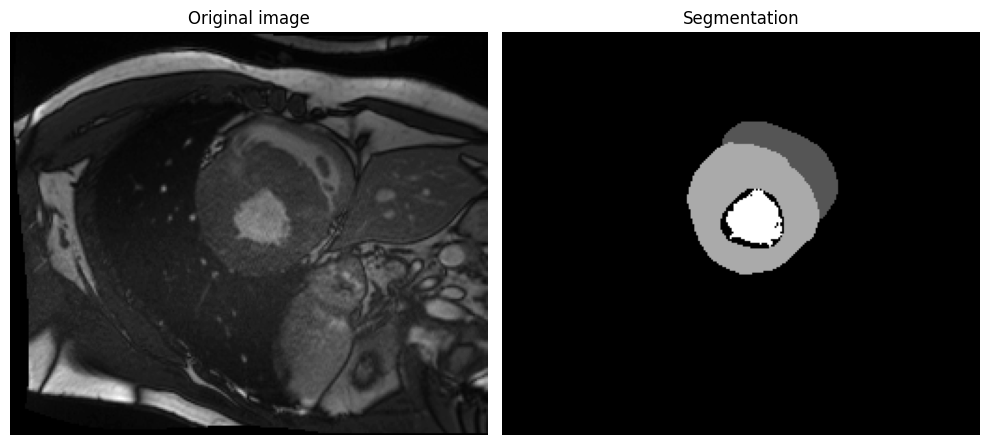

In [ ]:
number_case = 129
phase = "ED"
seg_suffix = "_complete_seg.nii"

plot_image_and_segmentation(f"{test_base_path}/{number_case}/", f"{number_case}_{phase}.nii", slice_idx=3, seg_suffix=seg_suffix)

## Data Preprocessing and Splitting

1. **Data Splitting:**
   - The dataset is split into training and testing sets using the `load_and_split_data_train` function. The training set consists of data from `train_dataset_path` and `train_base_path`, focusing on the first 100 samples (`id_range=range(1, 101)`).
   - `use_completed_seg=False` ensures that the segmentation process isn't pre-applied to the data, allowing the model to handle raw input.
   - This step creates `X_train_split`, `X_test_split` for the features and `y_train_split`, `y_test_split` for the labels.

2. **Class Distribution Check:**
   - The balance of the dataset is visualized using the `plot_class_distribution` function, which helps assess the distribution of the classes in the training and testing sets.

3. **Feature Normalization:**
   - The features are normalized using the `MinMaxScaler` to scale the data between 0 and 1, ensuring the model performs optimally with consistent feature magnitudes.
   - The scaler is applied separately to the training and testing data using the `normalize_features` function, which outputs the normalized features and the fitted scaler for later use.

This preprocessing is essential to prepare the data for the classification model.

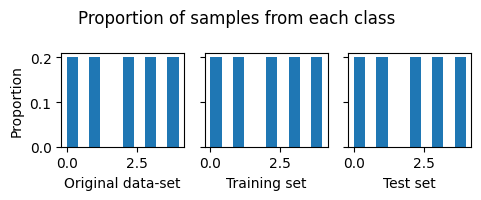

In [ ]:
# Split the data into training and testing sets. This function will also load the data and process it.
X_train_split, X_test_split, y_train_split, y_test_split = load_and_split_data_train(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False
)

# I check the balance of the data
plot_class_distribution(y_train_split, y_test_split, figsize=(5, 2))

# I use MinMaxScaler to normalize the features
X_train_split, X_test_split, scaler = normalize_features(X_train_split, X_test_split)

# Classification: Model Training, Evaluation and Prediction

I am using the simple segmentation and I will only use the other one in the last prediction: this is indicated in the parameter use_completed_seg = True.

In the following cases, use_completed_seg = False.

## 1. Basic Random Forest Classifier (splitting the data)

- The Random Forest Classifier is trained using the training data (split) and evaluated
on the test set (split).

- The complete test dataset is processed and features are scaled using the pre-trained scaler. A prediction is obtained for this.

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      0.75      0.86         4
         2.0       0.80      1.00      0.89         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
 [[4 0 0 0 0]
 [0 3 1 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]


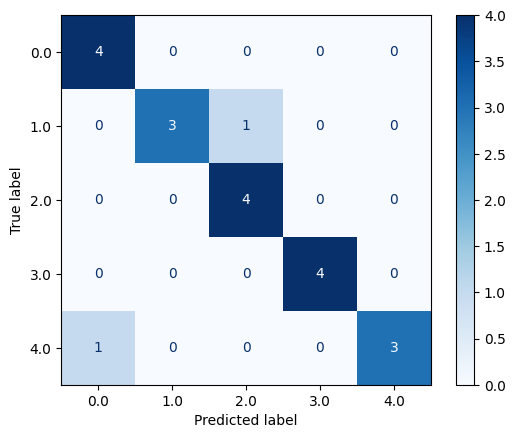

Accuracy: 90.00%
ROC AUC Score: 0.99
Predictions for the test dataset:
[0. 4. 3. 0. 2. 3. 4. 2. 1. 0. 3. 2. 1. 4. 3. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 2. 3. 3. 2. 0. 3. 1. 2. 3. 0. 1. 4. 2. 4.
 1. 4.]


In [ ]:
# Random Forest Classifier and evaluation of the model
rf_model = train_random_forest(X_train_split, y_train_split)
evaluate_model(rf_model, X_test_split, y_test_split)

# Load and process test dataset
X_test = process_dataset(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=False # I use SIMPLE_SEG
)

# Scale the features using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Make predictions using the trained model
y_pred = rf_model.predict(X_test_scaled)

print("Predictions for the test dataset:")
print(y_pred)

## 2. Random Forest with Separate Training Process

- Another approach for model training where the dataset is loaded separately, followed by processing and normalizing the features.

- After normalizing, the Random Forest model is trained and predictions are made on the test set.

Here X_test is processed and is used in the rest of the code.

In [ ]:
# Loading the training dataset (processing and shuffling)
######### X_train, y_train ###########
X_train, y_train = load_training_data(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False
)

# Processing the test dataset
############ X_test ##############
X_test = process_dataset(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=False # I use SIMPLE SEG
)

# Normalizing the features
X_train, X_test, scaler = normalize_features(X_train, X_test)

# Training the Random Forest model
rf_model = train_random_forest(X_train, y_train)

# Predicting the test set
y_pred = rf_model.predict(X_test)
print("Predictions for the test dataset:")
print(y_pred)



Predictions for the test dataset:
[0. 4. 0. 0. 2. 1. 4. 2. 1. 0. 3. 2. 1. 4. 3. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 2. 3. 3. 2. 4. 3. 1. 1. 3. 0. 1. 4. 2. 4.
 1. 4.]


## 3. Random Forest with Cross Validation

A Random Forest model is trained using cross-validation to tune the hyperparameters, to get a more generalized and robust model.

A grid of hyperparameters is defined, and the model is trained with cross-validation (cv = 5).

In [ ]:
# Define the model and param grid
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Call the generic training function
rf_model, y_pred, best_params = train_model_with_cv(
    model=rf,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

print("Predictions for the test dataset:")
print(y_pred)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy (CV): 0.9000
Predictions for the test dataset:
[0. 4. 0. 0. 2. 1. 4. 2. 1. 0. 3. 2. 1. 4. 3. 2. 4. 4. 4. 1. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 2. 3. 3. 2. 0. 3. 1. 2. 3. 0. 1. 4. 2. 4.
 1. 4.]


## 4. XGBoost Classifier with Hyperparameter Tuning

The XGBoost model is defined and trained similarly to the Random Forest model but with a focus on different hyperparameters (e.g., learning rate, subsample, and colsample_bytree).

Cross-validation is used to tune these hyperparameters and evaluate the model's performance.

In [ ]:
# Define model and hyperparameter grid
xgb = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use the general training function from models_and_cv.py
xgb_model, y_pred_xgb, best_xgb_params = train_model_with_cv(
    model=xgb,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

print("Best parameters:", best_xgb_params)
print("Predictions:", y_pred_xgb)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\pdalm\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best accuracy (CV): 0.8900
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Predictions: [0 4 0 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 1 0 1 0 1 3 2 4 0 3 0 0 1 2 3 2 3 3
 2 0 3 1 2 3 0 1 4 2 4 1 4]


## 5. PCA + Random Forest Classifier

Principal Component Analysis (PCA) is applied to reduce the dimensionality of the feature space.

The Random Forest model is then evaluated using PCA-transformed data.

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Evaluate using PCA + cross-validation
mean_acc, std_acc, scores = evaluate_pca_pipeline_with_cv(
    X=X_train,
    y=y_train,
    classifier=rf,
    n_components=14,
    cv=5,
    scoring='accuracy'
)

Accuracy with PCA: 0.8000 ± 0.0775


# Feature Importance Analysis with Random Forest

In this section, I use a Random Forest classifier to compute the feature importances from the training dataset. By assessing the contribution of each feature, the most relevant variables that impact the model's predictions are identified. This helps to prioritize the most significant features for the predictions. The top 14 features are then selected based on their importance, and we visualize the feature importances with a bar plot for better understanding.

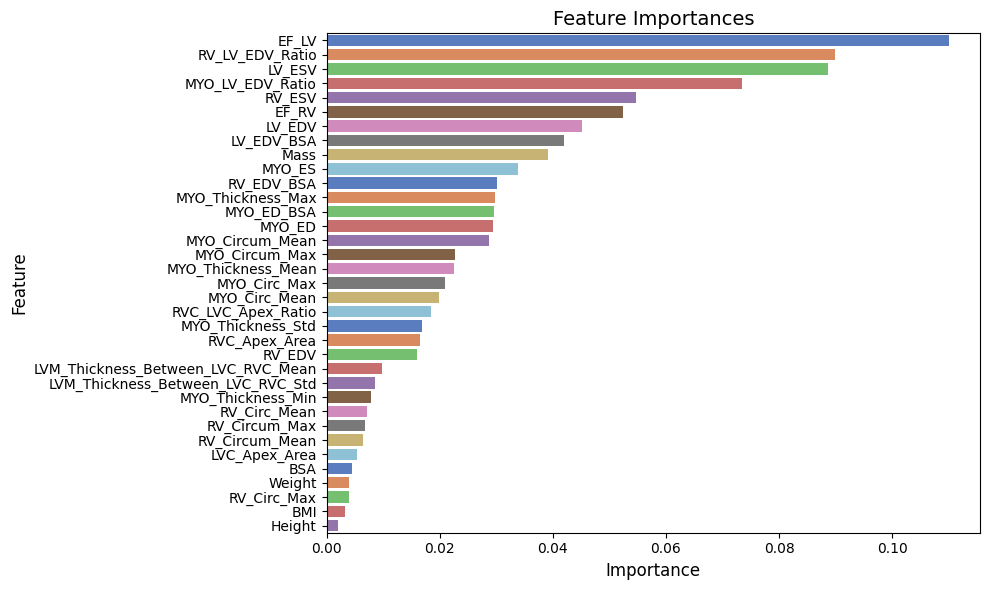

In [ ]:
feature_names_list = [
            'Height', 'Weight',
            # High Priority
            'EF_LV',                     # Ejection Fraction of Left Ventricle
            'EF_RV',                     # Ejection Fraction of Right Ventricle
            'LV_EDV_BSA',                # LV volume normalized by BSA
            'RV_EDV_BSA',                # RV volume normalized by BSA
            'MYO_ED_BSA',                # Myocardial volume normalized by BSA
            'Mass',                      # Estimated myocardial mass
            'RVC_LVC_Apex_Ratio',        # Ratio between RV and LV areas at apex
            'MYO_Thickness_Mean',        # Mean thickness of myocardium
            'MYO_Thickness_Std',         # Std of myocardial thickness
            'LVM_Thickness_Between_LVC_RVC_Mean',  # Mean thickness between LVC and RVC
            'LVM_Thickness_Between_LVC_RVC_Std',   # Std of thickness between LVC and RVC

            # Medium Priority
            'MYO_Circ_Max',              # Max circumference of MYO
            'RV_Circ_Max',               # Max circumference of RV
            'MYO_Circ_Mean',              # Mean circumference of MYO
            'RV_Circ_Mean',              # Mean circumference of RV
            'MYO_Thickness_Max',         # Max myocardial thickness
            'MYO_Thickness_Min',         # Min myocardial thickness
            'BMI',                       # Body Mass Index
            'RV_LV_EDV_Ratio',           # Volume ratio RV / LV
            'MYO_LV_EDV_Ratio',          # Volume ratio MYO / LV

            # Low Priority
            'LV_EDV',                    # Raw LV ED volume
            'LV_ESV',                    # Raw LV ES volume
            'RV_EDV',                    # Raw RV ED volume
            'RV_ESV',                    # Raw RV ES volume
            'MYO_ED',                    # Raw myocardial ED volume
            'MYO_ES',                    # Raw myocardial ES volume
            'BSA',                       # Body Surface Area
            'RVC_Apex_Area',             # RV area at apex
            'LVC_Apex_Area',              # LV area at apex

            'MYO_Circum_Mean',
            'MYO_Circum_Max',
            'RV_Circum_Mean',
            'RV_Circum_Max']

# Train the model
X_train_df = pd.DataFrame(X_train, columns=feature_names_list)
clf = RandomForestClassifier(random_state=42, **best_params)
clf.fit(X_train_df, y_train)

# Compute feature importances and sort them
importances = clf.feature_importances_
feature_names = X_train_df.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp_df,
    x='Importance',
    y='Feature',
    palette='muted'
)

plt.title("Feature Importances", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
best_features = feat_imp_df.head(14)['Feature'].tolist()
print("Best features:", best_features)

Best features: ['EF_LV', 'RV_LV_EDV_Ratio', 'LV_ESV', 'MYO_LV_EDV_Ratio', 'RV_ESV', 'EF_RV', 'LV_EDV', 'LV_EDV_BSA', 'Mass', 'MYO_ES', 'RV_EDV_BSA', 'MYO_Thickness_Max', 'MYO_ED_BSA', 'MYO_ED']


## Cross-Validation with top 14 most important features and Random Forest model tuning

Here, I focus on improving the model's performance by using the top 14 features identified in the previous section. The dataset is split into training and testing sets, and cross-validation is performed to fine-tune the Random Forest model. We search for the best hyperparameters for the model through grid search and evaluate the optimized model's performance. The final model is trained on the selected features and evaluated to assess its predictive capabilities.

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best accuracy (CV): 0.8875
Best parameters for top 14 features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89         4
         1.0       1.00      0.75      0.86         4
         2.0       0.80      1.00      0.89         4
         3.0       1.00      1.00      1.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
 [[4 0 0 0 0]
 [0 3 1 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [1 0 0 0 3]]


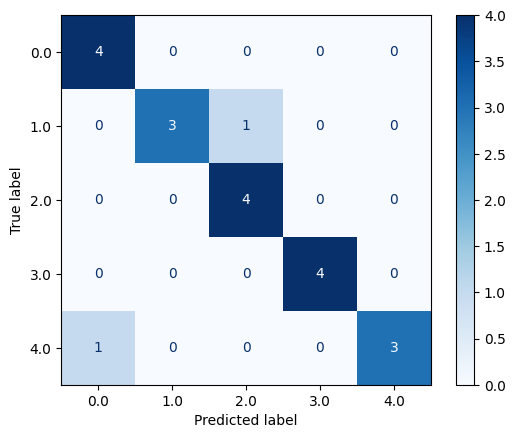

Accuracy: 90.00%
ROC AUC Score: 1.00


In [ ]:
# Select the top 14 features based on importance
top_14_features = feat_imp_df['Feature'].head(14).values
X_train_top_14 = X_train_df[top_14_features].values
X_train_top_14, X_test_top_14, y_train_split, y_test_split = train_test_split(
    X_train_top_14,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)
# I find the best parameters for the Random Forest model using cross-validation
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Use the general training function
rf_model, y_pred, best_params_split = train_model_with_cv(
    model=rf,
    param_grid=param_grid,
    X_train=X_train_top_14,
    y_train=y_train_split,
    X_test=X_test_top_14,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)
print("Best parameters for top 14 features:", best_params_split)
rf = RandomForestClassifier(random_state=42, **best_params_split)
rf.fit(X_train_top_14, y_train_split)

evaluate_model(rf, X_test_top_14, y_test_split)

# My predictions

## Prediction with top 14 features using Random Forest

In this section, the model is trained and tested using only the 14 most important features identified from the feature importance analysis. A Random Forest classifier is used, and cross-validation is applied to optimize the hyperparameters. The predictions are then made, and the results are saved into a submission file for evaluation.

In [ ]:
# i use load_training_data which considers only the best features
X_train, y_train = load_training_data_14_features(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False
)

# Processing the test dataset
X_test = process_data_best_features(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=False # I USE SIMPLE SEG
)

# Normalizing the features
X_train, X_test, scaler = normalize_features(X_train, X_test)

############################################################################################

# I find the best parameters for the Random Forest model using cross-validation
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# I apply CV to find the best parameters for the Random Forest model
rf_model, y_pred, best_params_split = train_model_with_cv(
    model=rf,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

print("Best parameters for best 14 features:", best_params_split)
print("Predictions for the test dataset:")
print(y_pred)

# Save the submission file
save_submission(y_pred, 'submission_14_features.csv')


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy (CV): 0.9300
Best parameters for best 14 features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Predictions for the test dataset:
[0. 4. 3. 0. 2. 1. 4. 2. 1. 0. 3. 1. 1. 4. 3. 2. 4. 4. 4. 1. 0. 2. 0. 2.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 2. 3. 3. 1. 0. 3. 1. 1. 3. 0. 1. 4. 2. 4.
 1. 4.]
submission_14_features.csv saved successfully.


# Prediction with a different set of features (submitted)
88% accuracy in hidden data

Here, redundant features are dropped to simplify the model while retaining the most relevant ones. The Random Forest model is trained on this reduced feature set, and cross-validation is applied to find the best parameters. The predictions are generated, and a submission file is created with the output.

In [ ]:
X_train, y_train = load_training_data(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False,
    dropFeatures=True #!!!
)

# Processing the test dataset
X_test = process_dataset(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=False, # i use SIMPLE SEG
    dropFeatures=True #!!!
)

# Normalizing the features
X_train, X_test, scaler = normalize_features(X_train, X_test)

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# I apply CV to find the best parameters for the Random Forest model
rf_model, y_pred, best_params_split = train_model_with_cv(
    model=rf,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

print("Best parameters for these new features:", best_params_split)
print("Predictions for the test dataset:")
print(y_pred)

# Save the submission file
save_submission(y_pred, 'submission_voxel_final.csv')

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy (CV): 0.9200
Best parameters for these new features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Predictions for the test dataset:
[0. 4. 3. 0. 2. 1. 4. 2. 1. 0. 3. 2. 1. 4. 3. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 2. 3. 2. 3. 3. 2. 0. 3. 1. 2. 3. 0. 1. 4. 2. 4.
 1. 4.]
submission_voxel_final.csv saved successfully.


## Prediction with AdaBoost with this new set of features

This part focuses on using AdaBoost, an ensemble learning method, to make predictions based on the top 14 most important features. The AdaBoost classifier is tuned with cross-validation, and predictions are made. The results are stored in a separate submission file for comparison with the other models.

In [ ]:
# Load training and testing data
X_train, y_train = load_training_data(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False
)

X_test = process_dataset(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=False
)

# Normalize features
X_train, X_test, scaler = normalize_features(X_train, X_test)

# Define AdaBoost and hyperparameter grid
ada = AdaBoostClassifier(random_state=42, algorithm='SAMME')

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Train AdaBoost with CV
ada_model, y_pred_ada, best_params_ada = train_model_with_cv(
    model=ada,
    param_grid=param_grid_ada,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

print("Best parameters for AdaBoost:", best_params_ada)
print("Predictions for the test dataset:")
print(y_pred_ada)

# Save predictions
save_submission(y_pred_ada, 'submission_ada_final.csv')

Best parameters: {'learning_rate': 1.0, 'n_estimators': 50}
Best accuracy (CV): 0.7900
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
Predictions for the test dataset:
[0. 4. 3. 0. 2. 1. 4. 2. 0. 0. 3. 2. 1. 4. 3. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 0. 3. 0. 0. 1. 1. 3. 2. 3. 3. 2. 0. 3. 1. 1. 3. 0. 1. 4. 2. 4.
 1. 4.]
submission_ada_final.csv saved successfully.


## Prediction with Custom Segmentation using Random Forest (optional part)

In this section, the model uses custom segmentation of the left ventricle (LV) to process the data. The Random Forest model is again tuned with cross-validation. The predictions made with this complex segmentation approach are saved in a submission file for further analysis.

In [ ]:
# Processing and shuffling the training dateset
X_train, y_train = load_training_data(
    metadata_path=train_dataset_path,
    base_path=train_base_path,
    id_range=range(1, 101),
    use_completed_seg=False,
    dropFeatures = True #!!!
)

# Processing the test dataset
X_test = process_dataset(
    metadata_path=test_dataset_path,
    base_path=test_base_path,
    id_range=range(101, 151),
    use_completed_seg=True, # now I am using my own segmentation of LV
    dropFeatures = True #!!!
)

# Normalizing the features
X_train, X_test, scaler = normalize_features(X_train, X_test)

############################################################################################

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# I apply CV to find the best parameters for the Random Forest model
rf_model, y_pred, best_params_split = train_model_with_cv(
    model=rf,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

print("Best parameters for these new features:", best_params_split)
print("Predictions for the test dataset:")
print(y_pred)

# Save the submission file
save_submission(y_pred, 'submission_my_seg_final.csv')

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy (CV): 0.9200
Best parameters for these new features: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Predictions for the test dataset:
[0. 4. 4. 0. 2. 1. 4. 2. 0. 0. 1. 2. 1. 4. 1. 2. 4. 4. 4. 2. 0. 1. 0. 1.
 3. 2. 4. 4. 3. 0. 4. 1. 2. 3. 2. 3. 3. 2. 0. 3. 1. 2. 3. 0. 1. 4. 2. 4.
 1. 4.]
submission_my_seg_final.csv saved successfully.
